In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
print(sys.executable)


/home/onizuka/Documents/Project M1/venv/bin/python3.10


In [3]:
data= pd.read_csv('final_data.csv')
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI_14',
       'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'PROC_9', 'EMA_10', 'EMA_30',
       'Pct_Change', 'Log_Returns', 'Volatility_10', 'Volatility_30',
       'Future_Close', 'Price_Change', 'Signal'],
      dtype='object')

## Split Data into Training and Testing Sets

In [4]:
# Define the list of features
features = ['RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 
            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
            'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns', 
            'Volatility_10', 'Volatility_30']

# Define the features (X)
X = data[features]

# Define the target variable (y)
y = data['Signal']


In [5]:
y = y.replace({2: 1})  # Replace '2' with '1'


In [6]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

##  Feature Scaling


In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

In [8]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (8700, 15)
y_train shape: (8700,)


## LightGboost

from lightgbm import LGBMClassifier
from sklearn.base import is_classifier

# Initialize LightGBM model
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Check if the model is a classifier
print(is_classifier(model))  # Should return True

import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Perform cross-validation
cv_results = lgb.cv(
    params={
        'objective': 'binary',
        'metric': 'binary_logloss'  # Use binary_logloss instead of binary_error
    },
    train_set=lgb.Dataset(X_train_scaled, label=y_train),
    num_boost_round=100,
    nfold=5,
    stratified=True,
    shuffle=True
)

# Step 4: Get binary log loss
if 'valid binary_logloss-mean' in cv_results:
    binary_logloss_mean = np.mean(cv_results['valid binary_logloss-mean'])
    print("Cross-Validation Binary Logloss:", binary_logloss_mean)
else:
    print("'valid binary_logloss-mean' not found in cv_results.")

# If you want to calculate accuracy manually, train the model separately
final_model = lgb.LGBMClassifier(objective='binary', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)


## Hyperparameter

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(objective='binary', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


##  Rebuild the model with Hyperparameters 

# Train the model with the best parameters
best_model = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=100, objective='binary', random_state=42)
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data with Tuned Parameters: {accuracy}")


import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = best_model.feature_importances_
features = X.columns

# Sort and plot
sorted_idx = feature_importances.argsort()
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM)")
plt.show()


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix LightGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 2. XGBoost Model


import xgboost as xgb
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


# Step 1: Define the list of features and target variable
features = [
    'RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns',
    'Volatility_10', 'Volatility_30'
]
X = data[features]
y = data['Signal'].replace({2: 1})  # Map '2' to '1' for binary classification


# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Step 4: Define the Optuna optimization function
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }
    
    # Perform cross-validation using xgb.cv
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=10,
        seed=42,
        verbose_eval=False
    )
    
    # Return the mean of the test logloss
    return cv_results['test-logloss-mean'].min()


# Step 5: Run Optuna optimization
study = optuna.create_study(direction='minimize', study_name="XGBoost Hyperparameter Tuning")
study.optimize(objective, n_trials=50)  # Adjust n_trials for more or fewer experiments

# Step 6: Display the best hyperparameters
print("Best Hyperparameters:", study.best_params)


# Step 7: Train the final model with the best hyperparameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False  # Avoid deprecation warning
})
final_model = xgb.XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train_scaled, y_train)


# Step 8: Evaluate the model on the test set
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  XgBooost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Random Forest Classifier

In [24]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss


def objectiveRD(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    # Créer le modèle RandomForest
    model = RandomForestClassifier(**params, random_state=42)
    
    # Évaluation avec validation croisée
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
    
    return -np.mean(scores)  # Minimiser la log loss

# Étape d'optimisation avec Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objectiveRD, n_trials=50)

[I 2025-01-22 21:27:06,691] A new study created in memory with name: no-name-b7fafd50-9f9f-49dc-9cec-957542921235
[I 2025-01-22 21:27:29,204] Trial 0 finished with value: 0.9101683957256602 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.9101683957256602.
[I 2025-01-22 21:27:35,492] Trial 1 finished with value: 0.5329273740388066 and parameters: {'n_estimators': 134, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.5329273740388066.
[I 2025-01-22 21:27:38,496] Trial 2 finished with value: 0.553384984307961 and parameters: {'n_estimators': 112, 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.5329273740388066.
[I 2025-01-22 21:27:46,425] Trial 3 finished with value: 0.54377215277483

In [25]:
# Récupérer les meilleurs hyperparamètres trouvés par Optuna
best_params = study.best_params

# Ajouter les paramètres fixes nécessaires pour RandomForestClassifier
best_params.update({
    'random_state': 42
})

# Créer et entraîner le modèle final avec les meilleurs hyperparamètres
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, max_depth=19, min_samples_leaf=6,
                       min_samples_split=9, n_estimators=172, random_state=42)

In [26]:
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.782528735632184

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.47      0.58       698
           1       0.79      0.93      0.85      1477

    accuracy                           0.78      2175
   macro avg       0.78      0.70      0.72      2175
weighted avg       0.78      0.78      0.77      2175



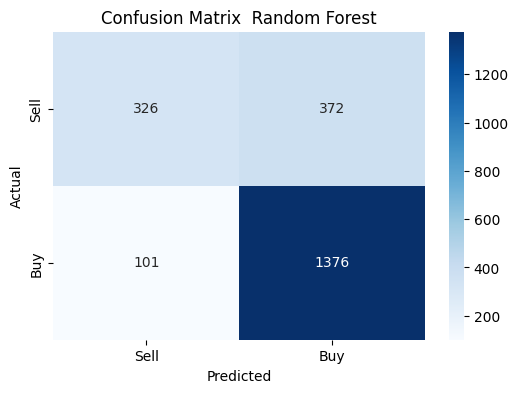

In [27]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save Final Model (The best Model)

In [ ]:
# Save the model for future use
joblib.dump(final_model, "random_forest_model.pkl")
print("Model saved successfully.")

